<div class="alert alert-block alert-success" style="font-size:20px; font-family:verdana; text-align: center; color: blue;">
&nbsp;<b><u>Yarışma Çözüm Özeti:</u>


*  yarışmada tahminleri yapabilmek için 2 model oluşturdum 1. modeli ürün alanları ve almayanları tespit edebilmek için oluşturdum.İlk modelde ürün alacakları iyi tahminlemek önemliydi o yüzden ürün alanların f1 skorunu olabildiğince yükseltmeye çalıştım ve lgb,cat,xgb modellerine, 2 sınıf için ağırlık vererek voting_classifier ile eğitimi tamamladım. 2. modelde ise ürün alacak olarak tahminlenen kullanıcıların hangi ürünü alabilceğini tahminlemeye çalıştım.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import jaccard_score
import lightgbm as lgb
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
özellikler = pd.read_excel("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/Urun Ozellikleri.xlsx")
öz = özellikler[özellikler["Ürün "].isin(["HU14","HU07","HU06","HU19","HU12","HU11","HU15"])]

In [3]:
train = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv") 
test = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv")



num_values = train.select_dtypes(include=["int","float"]).columns
cat_values = train.columns[~(train.columns.isin(num_values))]


/tmp/ipykernel_18/441641331.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv")
/tmp/ipykernel_18/441641331.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv")


<div class="alert alert-block alert-success" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Veri İncelemesi<br>
</div>

Text(0.5, 1.0, 'Ürün Alan ve Almayan Kullanıcıların Dağılımı')

<Figure size 640x480 with 0 Axes>

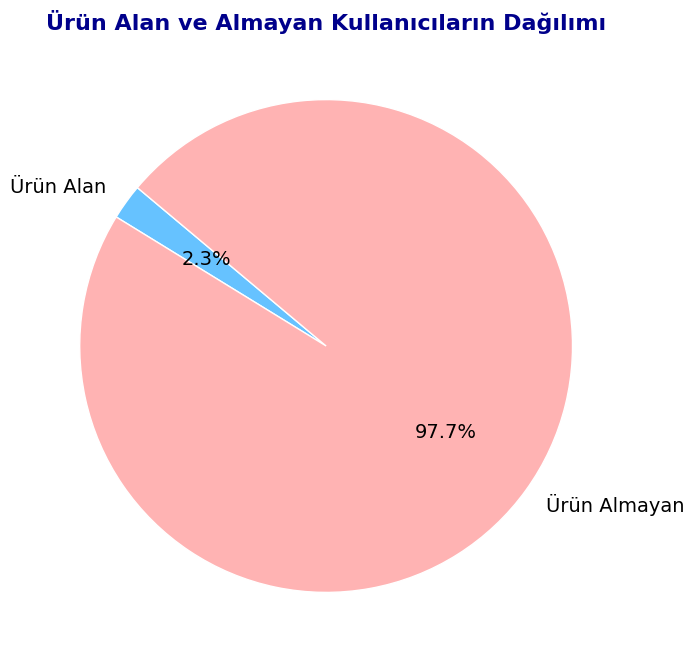

In [4]:
labels = ['Ürün Alan', 'Ürün Almayan']
sizes = [19949, 832770]
colors = ['#66c2ff', '#ffb3b3']
plt.figure()
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid") 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14, 'color': 'black'})
plt.title('Ürün Alan ve Almayan Kullanıcıların Dağılımı', fontsize=16, color='darkblue', fontweight='bold')


Text(0.5, 1.0, 'Ürün Alan Kullanıcıların Aldığı Ürünlerin Dağılımı')

<Figure size 1500x1000 with 0 Axes>

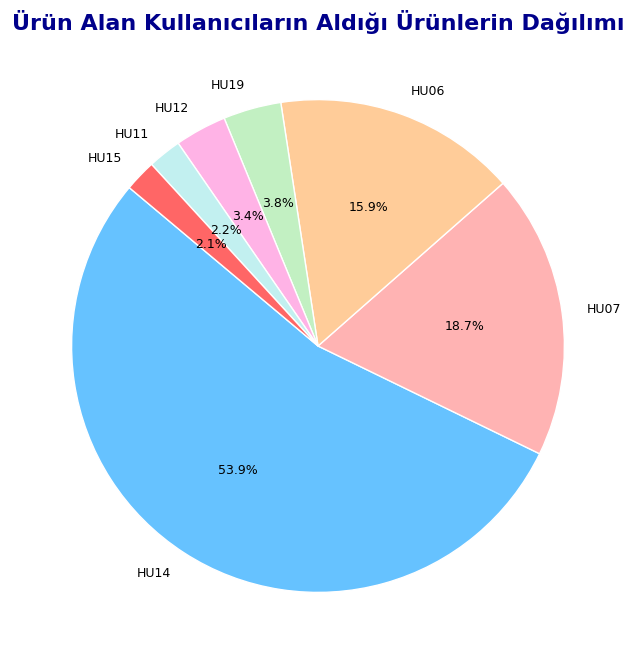

In [5]:
plt.figure(figsize=(15, 10))
labels = ['HU14', 'HU07', 'HU06', 'HU19', 'HU12', 'HU11', 'HU15']
sizes = [10754, 3728, 3178, 759, 676, 439, 415]
colors = ['#66c2ff', '#ffb3b3', '#ffcc99', '#c2f0c2', '#ffb3e6', '#c2f0f0', '#ff6666']


plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 9, 'color': 'black'})
plt.title('Ürün Alan Kullanıcıların Aldığı Ürünlerin Dağılımı', fontsize=16, color='darkblue', fontweight='bold')

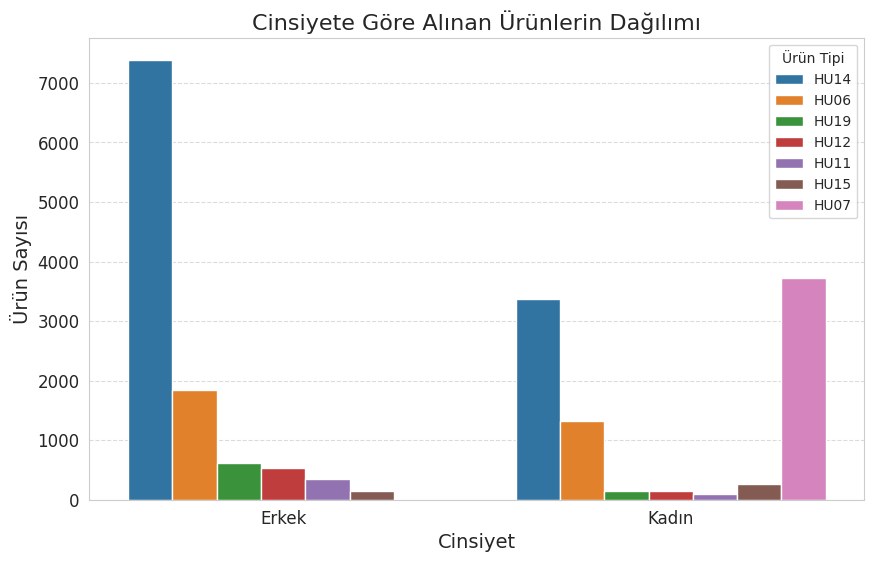

In [6]:
df = train[train.LABEL!="UA"].copy()
df['PP_CINSIYET'] = df['PP_CINSIYET'].map({1: 'Erkek', 2: 'Kadın'})

product_counts = df.groupby("PP_CINSIYET")["LABEL"].value_counts().reset_index(name='Counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='PP_CINSIYET', y='Counts', hue='LABEL', data=product_counts)


plt.title('Cinsiyete Göre Alınan Ürünlerin Dağılımı', fontsize=16)
plt.xlabel('Cinsiyet', fontsize=14)
plt.ylabel('Ürün Sayısı', fontsize=14)
plt.legend(title='Ürün Tipi')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

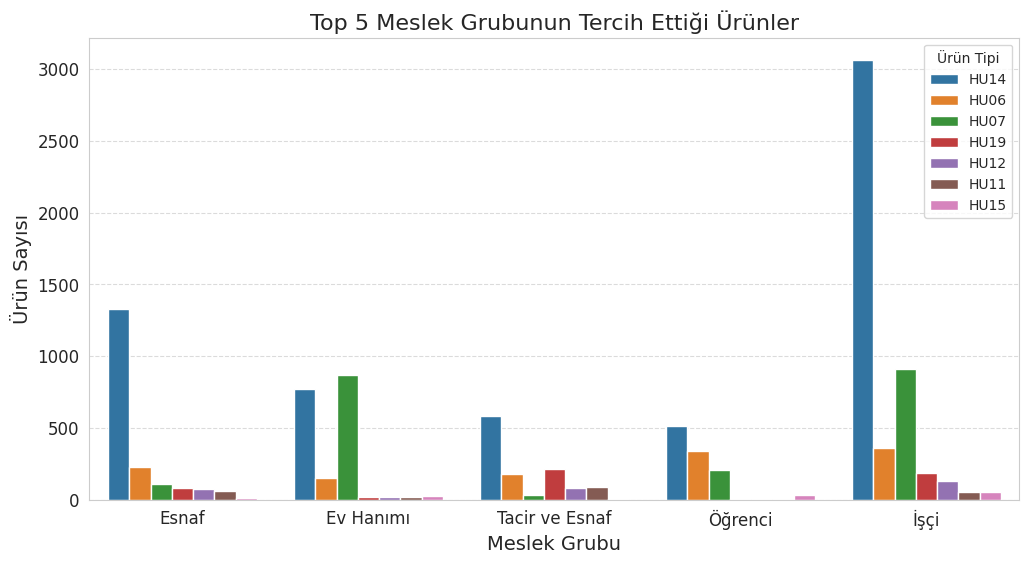

In [7]:
df = train[train.LABEL!="UA"].copy()
top_5_professions = df["PP_MESLEK"].value_counts()[:5].index
filtered_data = df[df["PP_MESLEK"].isin(top_5_professions)]
product_counts_by_profession = filtered_data.groupby("PP_MESLEK")["LABEL"].value_counts().reset_index(name='Counts')


plt.figure(figsize=(12, 6))
sns.barplot(x='PP_MESLEK', y='Counts', hue='LABEL', data=product_counts_by_profession)


plt.title('Top 5 Meslek Grubunun Tercih Ettiği Ürünler', fontsize=16)
plt.xlabel('Meslek Grubu', fontsize=14)
plt.ylabel('Ürün Sayısı', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Ürün Tipi')
plt.grid(axis='y', linestyle='--', alpha=0.7)


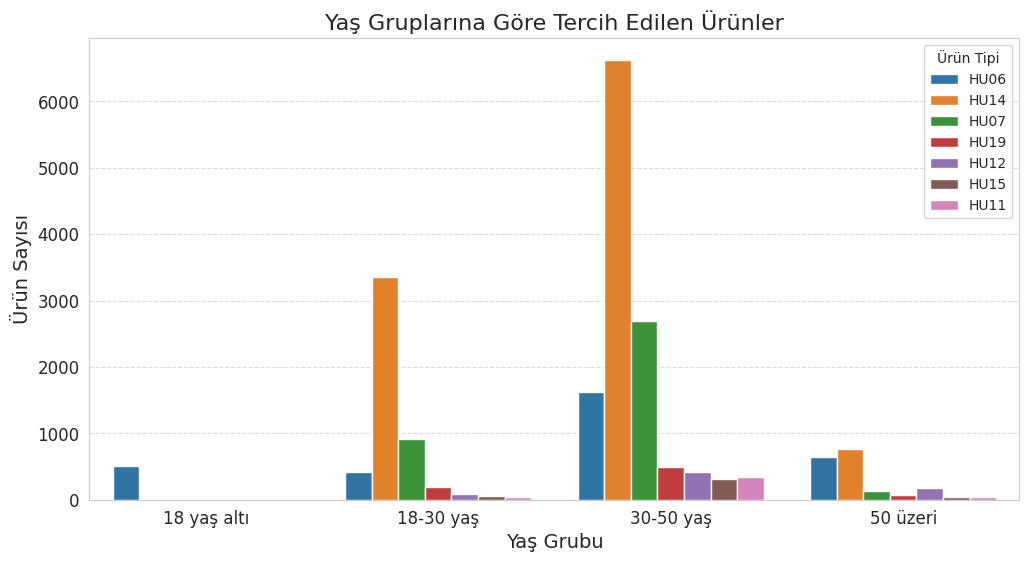

In [8]:
df = train[train.LABEL != "UA"].copy()

df["PP_YAS"] = df.PP_YAS / 12
def get_age_group(age):
    if age < 18:
        return '18 yaş altı'
    elif 18 <= age < 30:
        return '18-30 yaş'
    elif 30 <= age < 50:
        return '30-50 yaş'
    else:
        return '50 üzeri'

df['YAS_GRUBU'] = df['PP_YAS'].apply(get_age_group)
age_group_counts = df.groupby('YAS_GRUBU')["LABEL"].value_counts().reset_index(name='Counts')
plt.figure(figsize=(12, 6))
sns.barplot(x='YAS_GRUBU', y='Counts', hue='LABEL', data=age_group_counts)


plt.title('Yaş Gruplarına Göre Tercih Edilen Ürünler', fontsize=16)
plt.xlabel('Yaş Grubu', fontsize=14)
plt.ylabel('Ürün Sayısı', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Ürün Tipi')
plt.grid(axis='y', linestyle='--', alpha=0.7)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


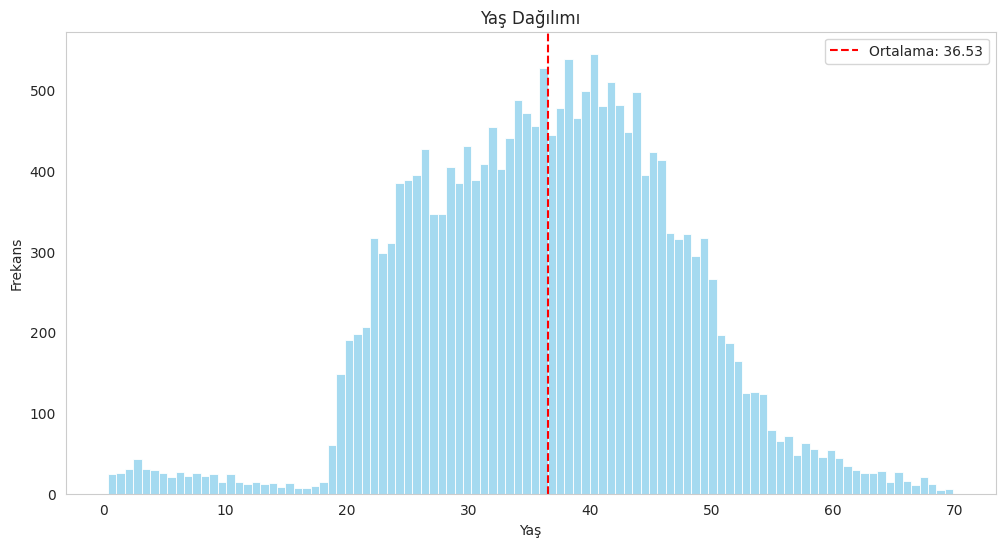

In [9]:
df = train[train.LABEL != "UA"].copy()
df["PP_YAS"] = df.PP_YAS / 12

plt.figure(figsize=(12, 6))
sns.histplot(df['PP_YAS'], bins=100, color='skyblue',)
plt.title('Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Frekans')


mean_age = df['PP_YAS'].mean()
median_age = df['PP_YAS'].median()


plt.axvline(mean_age, color='red', linestyle='--', label=f'Ortalama: {mean_age:.2f}')
plt.legend()  
plt.grid(False)


<div class="alert alert-block alert-success" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Veri Temizleme ve Yeni Özelliklerin Eklenmesi<br>
</div>

In [10]:
test.loc[test.PP_CINSIYET==1, "PP_CINSIYET"] = "erkek"
test.loc[test.PP_CINSIYET==2, "PP_CINSIYET"] = "kadın"


test.loc[test.PP_MUSTERI_SEGMENTI==101, "PP_MUSTERI_SEGMENTI"] = "A"
test.loc[test.PP_MUSTERI_SEGMENTI==102, "PP_MUSTERI_SEGMENTI"] = "B"
test.loc[test.PP_MUSTERI_SEGMENTI==103, "PP_MUSTERI_SEGMENTI"] = "C"
test.loc[test.PP_MUSTERI_SEGMENTI==104, "PP_MUSTERI_SEGMENTI"] = "D"
test.loc[test.PP_MUSTERI_SEGMENTI==105, "PP_MUSTERI_SEGMENTI"] = "E"
test.loc[test.PP_MUSTERI_SEGMENTI==106, "PP_MUSTERI_SEGMENTI"] = "F"


test.loc[test.PP_UYRUK==1, "PP_UYRUK"] = "TC"
test.loc[test.PP_UYRUK==2, "PP_UYRUK"] = "MK"
test.loc[test.PP_UYRUK==3, "PP_UYRUK"] = "YB"

/tmp/ipykernel_18/2651347257.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'erkek' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[test.PP_CINSIYET==1, "PP_CINSIYET"] = "erkek"
/tmp/ipykernel_18/2651347257.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[test.PP_MUSTERI_SEGMENTI==101, "PP_MUSTERI_SEGMENTI"] = "A"
/tmp/ipykernel_18/2651347257.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[test.PP_UYRUK==1, "PP_UYRUK"] = "TC"


In [11]:
train.loc[train.PP_CINSIYET==1, "PP_CINSIYET"] = "erkek"
train.loc[train.PP_CINSIYET==2, "PP_CINSIYET"] = "kadın"


train.loc[train.PP_MUSTERI_SEGMENTI==101, "PP_MUSTERI_SEGMENTI"] = "A"
train.loc[train.PP_MUSTERI_SEGMENTI==102, "PP_MUSTERI_SEGMENTI"] = "B"
train.loc[train.PP_MUSTERI_SEGMENTI==103, "PP_MUSTERI_SEGMENTI"] = "C"
train.loc[train.PP_MUSTERI_SEGMENTI==104, "PP_MUSTERI_SEGMENTI"] = "D"
train.loc[train.PP_MUSTERI_SEGMENTI==105, "PP_MUSTERI_SEGMENTI"] = "E"
train.loc[train.PP_MUSTERI_SEGMENTI==106, "PP_MUSTERI_SEGMENTI"] = "F"


train.loc[train.PP_UYRUK==1, "PP_UYRUK"] = "TC"
train.loc[train.PP_UYRUK==2, "PP_UYRUK"] = "MK"
train.loc[train.PP_UYRUK==3, "PP_UYRUK"] = "YB"


/tmp/ipykernel_18/1774507851.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'erkek' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train.PP_CINSIYET==1, "PP_CINSIYET"] = "erkek"
/tmp/ipykernel_18/1774507851.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train.PP_MUSTERI_SEGMENTI==101, "PP_MUSTERI_SEGMENTI"] = "A"
/tmp/ipykernel_18/1774507851.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train.PP_UYRUK==1, "PP_UYRUK"] = "TC"


In [12]:
other_meslekler = ['İşçi', 'Öğrenci', 'Ev Hanımı', 'Diğer', 'Öğretmen', 'Esnaf', 'Memur',
       'Serbest Meslek', 'Mühendis',
       'Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)', 'Danışman',
       'SSK-Sosyal Sigortalar Kurumu Emeklileri', 'Emekli', 'Akademisyen',
       'Banka', 'Tacir ve Esnaf', 'Ordu Mensubu', 'Hekim', 'Çiftçi',
       'Emekli (Vakıf,Sandık v.b.)', 'Finans Sektörü Çalışan',
       'İşyeri Sahibi/Ortağı', 'İş Adamı',]

# Veri çerçevesindeki meslekleri "other" kategorisine dönüştürme


train.loc[~train['PP_MESLEK'].isin(other_meslekler), 'PP_MESLEK'] = 'other'




month_mapping = {
    'OCAK': 1,
    'SUBAT': 2,
    'MART': 3,
    'NISAN': 4,
    'MAYIS': 5,
    'HAZIRAN': 6,
    'TEMMUZ': 7,
    'AGUSTOS': 8,
    'EYLUL': 9,
    'EKIM': 10,
    'KASIM': 11,
    'ARALIK': 12
}

train['FLAG'] = train['FLAG'].map(month_mapping)


train["SORU_GELIR_CVP"] =  train['SORU_GELIR_CVP'].str.replace(',', '.').astype(float)
train["SORU_GELIR_CVP"].astype(float)


pp_dummies = pd.get_dummies(train[["SORU_MEDENI_HAL_CVP","PP_MESLEK","SORU_YATIRIM_KARAKTERI_CVP","SORU_EGITIM_CVP","PP_CINSIYET","PP_MUSTERI_SEGMENTI","PP_UYRUK"]],dtype=int)
train = pd.concat([train,pp_dummies],axis=1)


train.drop(["SORU_MEDENI_HAL_CVP","PP_MESLEK","SORU_YATIRIM_KARAKTERI_CVP","SORU_EGITIM_CVP","PP_CINSIYET","PP_MUSTERI_SEGMENTI","PP_UYRUK"],axis=1,inplace=True)

In [13]:
train["yaş"] =  (train["PP_YAS"]/12).round()
test["yaş"] =  (test["PP_YAS"]/12).round()


data = {
    'IL': range(1, 82),
    'Enlem': [36.98542, 37.762990, 38.756217, 39.718993, 40.656314, 39.942928, 36.896126, 41.181310, 37.838044, 39.644878,
              40.142960, 38.88472, 38.400664, 40.732006, 37.718293, 40.182816, 40.146777, 40.600190, 40.549853, 37.783026,
              37.9137, 41.675907, 38.6763, 39.75, 39.905994, 39.766724, 37.062931, 40.917921, 40.458673, 37.578120, 36.202621,
              37.762627, 36.810307, 41.046419, 38.423652, 40.601469, 41.378133, 38.722100, 41.735547, 39.146209, 40.765600,
              37.872817, 39.419993, 38.355390, 38.614027, 37.582047, 37.313051, 37.215266, 38.732415, 38.623861, 37.969110,
              40.985592, 41.025113, 40.773626, 41.28157, 37.927462, 42.026596, 39.750528, 40.978127, 40.323397, 41.001289,
              39.108101, 37.1586, 38.678883, 38.501287, 39.820954, 41.452650, 38.370386, 40.250858, 37.181200, 39.849998,
              37.882999, 37.522781, 41.633178, 41.112875, 39.895802, 40.657659, 41.200069, 36.717999, 37.074695, 40.839377],
    'Boylam': [35.32502, 38.277298, 30.537846, 43.047663, 35.837068, 32.860481, 30.713081, 41.820537, 27.845571, 27.885361,
               29.979159, 40.496391, 42.108971, 31.607052, 30.282248, 29.066148, 26.408220, 33.616304, 34.953694, 29.096246,
               40.224899, 26.553608, 39.221802, 39.5, 41.273784, 30.525608, 37.378159, 38.389876, 39.478961, 43.733805,
               36.160045, 30.553612, 34.620414, 29.033115, 27.142797, 43.097496, 33.776539, 35.489122, 27.224502, 34.160577,
               29.940659, 32.491991, 29.985721, 38.333476, 27.429533, 36.926934, 40.732555, 28.363718, 41.489878, 34.712756,
               34.678619, 37.879123, 40.516397, 30.403235, 36.33812, 41.942270, 35.151245, 37.015028, 27.511091, 36.552149,
               39.716549, 39.548199, 38.797901, 29.404976, 43.372931, 34.808617, 31.790032, 34.026986, 40.202831, 33.222315,
               33.5, 41.130901, 42.459438, 32.338396, 42.702389, 44.040821, 29.268905, 32.629601, 37.116901, 36.246347,
               31.159454]
}

df = pd.DataFrame(data)

train = train.merge(df,on="IL",how="left")





train["yurtdışı"] =  train["IL"].apply(lambda x : 1 if x==0 else 0)

In [14]:
train["büyük_18"] =  train.yaş.apply(lambda x : 1 if x>17.9 else 0)
train["büyük_65"] =  train.yaş.apply(lambda x : 1 if x>64.9 else 0)
train["küçük_15"] =  train.yaş.apply(lambda x : 1 if x>15.1 else 0)

train["18_60"] =  train.yaş.apply(lambda x : 1 if x>17.9 and x<60.1 else 0)
train["18_50"] =  train.yaş.apply(lambda x : 1 if x>17.9 and x<50.1 else 0)




test["büyük_18"] =  test.yaş.apply(lambda x : 1 if x>17.9 else 0)
test["büyük_65"] =  test.yaş.apply(lambda x : 1 if x>64.9 else 0)
test["küçük_15"] =  test.yaş.apply(lambda x : 1 if x>15.1 else 0)

test["18_60"] =  test.yaş.apply(lambda x : 1 if x>17.9 and x<60.1 else 0)
test["18_50"] =  test.yaş.apply(lambda x : 1 if x>17.9 and x<50.1 else 0)

In [15]:
test.loc[~test['PP_MESLEK'].isin(other_meslekler), 'PP_MESLEK'] = 'other'

month_mapping = {
    'OCAK': 1,
    'SUBAT': 2,
    'MART': 3,
    'NISAN': 4,
    'MAYIS': 5,
    'HAZIRAN': 6,
    'TEMMUZ': 7,
    'AGUSTOS': 8,
    'EYLUL': 9,
    'EKIM': 10,
    'KASIM': 11,
    'ARALIK': 12
}

test['FLAG'] = test['FLAG'].map(month_mapping)



test["SORU_GELIR_CVP"] =  test['SORU_GELIR_CVP'].str.replace(',', '.').astype(float)
test["SORU_GELIR_CVP"].astype(float)


pp_dummies = pd.get_dummies(test[["SORU_MEDENI_HAL_CVP","PP_MESLEK","SORU_YATIRIM_KARAKTERI_CVP","SORU_EGITIM_CVP","PP_CINSIYET","PP_MUSTERI_SEGMENTI","PP_UYRUK"]],dtype=int)
test = pd.concat([test,pp_dummies],axis=1)


test.drop(["SORU_MEDENI_HAL_CVP","PP_MESLEK","SORU_YATIRIM_KARAKTERI_CVP","SORU_EGITIM_CVP","PP_CINSIYET","PP_MUSTERI_SEGMENTI","PP_UYRUK"],axis=1,inplace=True)


test["yaş"] =  (test["PP_YAS"]/24).round()
test["büyük_18"] =  test.yaş.apply(lambda x : 1 if x>19.9 else 0)

data = {
    'IL': range(1, 82),
    'Enlem': [36.98542, 37.762990, 38.756217, 39.718993, 40.656314, 39.942928, 36.896126, 41.181310, 37.838044, 39.644878,
              40.142960, 38.88472, 38.400664, 40.732006, 37.718293, 40.182816, 40.146777, 40.600190, 40.549853, 37.783026,
              37.9137, 41.675907, 38.6763, 39.75, 39.905994, 39.766724, 37.062931, 40.917921, 40.458673, 37.578120, 36.202621,
              37.762627, 36.810307, 41.046419, 38.423652, 40.601469, 41.378133, 38.722100, 41.735547, 39.146209, 40.765600,
              37.872817, 39.419993, 38.355390, 38.614027, 37.582047, 37.313051, 37.215266, 38.732415, 38.623861, 37.969110,
              40.985592, 41.025113, 40.773626, 41.28157, 37.927462, 42.026596, 39.750528, 40.978127, 40.323397, 41.001289,
              39.108101, 37.1586, 38.678883, 38.501287, 39.820954, 41.452650, 38.370386, 40.250858, 37.181200, 39.849998,
              37.882999, 37.522781, 41.633178, 41.112875, 39.895802, 40.657659, 41.200069, 36.717999, 37.074695, 40.839377],
    'Boylam': [35.32502, 38.277298, 30.537846, 43.047663, 35.837068, 32.860481, 30.713081, 41.820537, 27.845571, 27.885361,
               29.979159, 40.496391, 42.108971, 31.607052, 30.282248, 29.066148, 26.408220, 33.616304, 34.953694, 29.096246,
               40.224899, 26.553608, 39.221802, 39.5, 41.273784, 30.525608, 37.378159, 38.389876, 39.478961, 43.733805,
               36.160045, 30.553612, 34.620414, 29.033115, 27.142797, 43.097496, 33.776539, 35.489122, 27.224502, 34.160577,
               29.940659, 32.491991, 29.985721, 38.333476, 27.429533, 36.926934, 40.732555, 28.363718, 41.489878, 34.712756,
               34.678619, 37.879123, 40.516397, 30.403235, 36.33812, 41.942270, 35.151245, 37.015028, 27.511091, 36.552149,
               39.716549, 39.548199, 38.797901, 29.404976, 43.372931, 34.808617, 31.790032, 34.026986, 40.202831, 33.222315,
               33.5, 41.130901, 42.459438, 32.338396, 42.702389, 44.040821, 29.268905, 32.629601, 37.116901, 36.246347,
               31.159454]
}

df = pd.DataFrame(data)

test = test.merge(df,on="IL",how="left")





test["yurtdışı"] =  test["IL"].apply(lambda x : 1 if x==0 else 0)



In [16]:
cols = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19']
suffix = '_'  

train = train.rename(columns={col: col + suffix for col in cols})


cols = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19']
suffix = '_'  

test = test.rename(columns={col: col + suffix for col in cols})

In [17]:
nans = train.isnull().sum()/len(train)
nans[nans>0.05]

SORU_YATIRIM_KARAKTERI_RG    0.844382
SORU_EGITIM_RG               0.149047
SORU_GELIR_CVP               0.495463
SORU_GELIR_RG                0.325901
SORU_COCUK_SAYISI_CVP        0.488508
SORU_COCUK_SAYISI_RG         0.488508
SON_AY_KATKI_MIKTARI         0.998851
SON_AY_KATKI_ADET            0.998851
SON_CEYREK_KATKI_MIKTARI     0.993409
SON_CEYREK_KATKI_ADET        0.993409
SON_SENE_KATKI_MIKTARI       0.982402
SON_SENE_KATKI_ADET          0.982402
dtype: float64

In [18]:
nans = train.isnull().sum()/len(train)

to_drop = nans[nans>0.05].index
train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)


nans = train.isnull().sum()/len(train)



train[["Boylam","Enlem"]] =  train[["Boylam","Enlem"]].fillna(0)
test[["Boylam","Enlem"]] =  test[["Boylam","Enlem"]].fillna(0)



train["SORU_MEDENI_HAL_RG"] =  train["SORU_MEDENI_HAL_RG"].fillna(0)
test["SORU_MEDENI_HAL_RG"] =  test["SORU_MEDENI_HAL_RG"].fillna(0)


nans = train.isnull().sum()/len(train)
nans[nans>0]


train = train.drop("MUSTERI_ID",axis=1)


In [19]:
train = train.rename(columns={
    'PP_MESLEK_Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)': 'emekli_bilinmiyor',
    'PP_MESLEK_Emekli (Vakıf,Sandık v.b.)': 'emekli_vakıf'
})

test = test.rename(columns={
    'PP_MESLEK_Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)': 'emekli_bilinmiyor',
    'PP_MESLEK_Emekli (Vakıf,Sandık v.b.)': 'emekli_vakıf'
})

In [20]:
train["total_odeme"]  = train[[ 
       'ODEME_TUTAR_0', 'ODEME_TUTAR_1', 
       'ODEME_TUTAR_2', 'ODEME_TUTAR_3', 
       'ODEME_TUTAR_4', 'ODEME_TUTAR_5', 
       'ODEME_TUTAR_6',  'ODEME_TUTAR_7', 
       'ODEME_TUTAR_8', 'ODEME_TUTAR_9', 
       'ODEME_TUTAR_10',  'ODEME_TUTAR_11',]].sum(axis=1)

test["total_odeme"]  = test[[ 
       'ODEME_TUTAR_0', 'ODEME_TUTAR_1', 
       'ODEME_TUTAR_2', 'ODEME_TUTAR_3', 
       'ODEME_TUTAR_4', 'ODEME_TUTAR_5', 
       'ODEME_TUTAR_6',  'ODEME_TUTAR_7', 
       'ODEME_TUTAR_8', 'ODEME_TUTAR_9', 
       'ODEME_TUTAR_10',  'ODEME_TUTAR_11',]].sum(axis=1)

In [21]:
train["total_vade"] =  train[[ 'VADE_TUTAR_0',
        'VADE_TUTAR_1', 'VADE_TUTAR_2',
      'VADE_TUTAR_3',  'VADE_TUTAR_4',
        'VADE_TUTAR_5',  'VADE_TUTAR_6',
       'VADE_TUTAR_7', 'VADE_TUTAR_8',
       'VADE_TUTAR_9',  'VADE_TUTAR_10',
       'VADE_TUTAR_11' ]].sum(axis=1)


test["total_vade"] =  test[[ 'VADE_TUTAR_0',
        'VADE_TUTAR_1', 'VADE_TUTAR_2',
      'VADE_TUTAR_3',  'VADE_TUTAR_4',
        'VADE_TUTAR_5',  'VADE_TUTAR_6',
       'VADE_TUTAR_7', 'VADE_TUTAR_8',
       'VADE_TUTAR_9',  'VADE_TUTAR_10',
       'VADE_TUTAR_11' ]].sum(axis=1)

In [22]:
train["full_odeme"] = train[["total_vade", "total_odeme"]].apply(lambda x: 1 if x["total_odeme"] >= x["total_vade"] else 0, axis=1)
test["full_odeme"] = test[["total_vade", "total_odeme"]].apply(lambda x: 1 if x["total_odeme"] >= x["total_vade"] else 0, axis=1)

<div class="alert alert-block alert-success" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Modelleme<br>
</div>

<div class="alert alert-block" style="font-size:18px; color: red; font-weight: bold;">
     &nbsp;Kullanıcıların Ürün Alıp veya Almayacağının Tahminlenmesi <br>
</div>

In [23]:
train["target"] =  train["LABEL"].apply(lambda x : "UA" if x=="UA" else "other")

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


model_train = train
scores = []
scores2 = []


proba_scores = []

mps = []

tests = []
preds = []
probalar = []

importance = []


skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skf.split(model_train.drop("target",axis=1), model_train.target):
    X_train, X_test = model_train.iloc[train_index,:], model_train.iloc[test_index,:]
    y_train, y_test = model_train.target[train_index], model_train.target[test_index]

    


    features = [ 'FLAG', 'PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG',
       'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11', 'ANAPARA',
       'GETIRI', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07',
       'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16',
       'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01',
       'HU02', 'HU03', 'HU04', 'HU05', 'HU06_', 'HU07_', 'HU10', 'HU11_',
       'HU12_', 'HU13', 'HU14_', 'HU15_', 'HU16', 'HU17', 'HU18', 'HU19_',
       'AKTIF_ILK_POLICE_RG', 'SORU_MEDENI_HAL_CVP_Divorced',
       'SORU_MEDENI_HAL_CVP_Marriage Cancelled', 'SORU_MEDENI_HAL_CVP_Married',
       'SORU_MEDENI_HAL_CVP_Other', 'SORU_MEDENI_HAL_CVP_Single',
       'SORU_MEDENI_HAL_CVP_Widowed', 'PP_MESLEK_Akademisyen',
       'PP_MESLEK_Banka', 'PP_MESLEK_Danışman', 'PP_MESLEK_Diğer',
       'PP_MESLEK_Emekli', 'emekli_bilinmiyor', 'emekli_vakıf',
       'PP_MESLEK_Esnaf', 'PP_MESLEK_Ev Hanımı',
       'PP_MESLEK_Finans Sektörü Çalışan', 'PP_MESLEK_Hekim',
       'PP_MESLEK_Memur', 'PP_MESLEK_Mühendis', 'PP_MESLEK_Ordu Mensubu',
       'PP_MESLEK_SSK-Sosyal Sigortalar Kurumu Emeklileri',
       'PP_MESLEK_Serbest Meslek','PP_MESLEK_Tacir ve Esnaf', 'PP_MESLEK_other', 'PP_MESLEK_Çiftçi',
       'PP_MESLEK_Öğrenci', 'PP_MESLEK_Öğretmen', 'PP_MESLEK_İş Adamı',
       'PP_MESLEK_İşyeri Sahibi/Ortağı', 'PP_MESLEK_İşçi',
       'SORU_YATIRIM_KARAKTERI_CVP_Bilge', 'SORU_YATIRIM_KARAKTERI_CVP_Cesur',
       'SORU_YATIRIM_KARAKTERI_CVP_Dengeli',
       'SORU_YATIRIM_KARAKTERI_CVP_Temkinli',
       'SORU_YATIRIM_KARAKTERI_CVP_Yetkin', 'SORU_EGITIM_CVP_(Diğer)',
       'SORU_EGITIM_CVP_Doktora', 'SORU_EGITIM_CVP_Lisans',
       'SORU_EGITIM_CVP_Lise', 'SORU_EGITIM_CVP_Yüksek Lisans',
       'SORU_EGITIM_CVP_Önlisans', 'SORU_EGITIM_CVP_İlköğretim',
       'PP_CINSIYET_erkek', 'PP_CINSIYET_kadın', 'PP_MUSTERI_SEGMENTI_A',
       'PP_MUSTERI_SEGMENTI_B', 'PP_MUSTERI_SEGMENTI_C',
       'PP_MUSTERI_SEGMENTI_D', 'PP_MUSTERI_SEGMENTI_E',
       'PP_MUSTERI_SEGMENTI_F', 'PP_UYRUK_MK', 'PP_UYRUK_TC', 'PP_UYRUK_YB',
       'yaş', 'Enlem', 'Boylam', 'yurtdışı', 'büyük_18', 'büyük_65',
       'küçük_15', '18_60', '18_50', 'total_odeme', 'total_vade', 'full_odeme',
 
    ]

 
    
    
    
    class_weights = {
    0: 1,
    1: 5
    
}
    
    classifier1 = lgb.LGBMClassifier(verbose=0,class_weight= class_weights,learning_rate=0.1,
                            n_estimators=1000)
    classifier2 = XGBClassifier(scale_pos_weight=4)
    classifier3 = CatBoostClassifier(silent=True,class_weights=class_weights)
    classifier4 = LogisticRegression(max_iter=1000)
    classifier5 = RandomForestClassifier()

 
    
    voting_classifier = VotingClassifier(estimators=[
        

         ('lgbm', classifier1),
         ('xgb', classifier2),
         ('cat', classifier3),
        
                                               
                                                 
                                           
                                                 
                                   
                                                                          ],voting='soft') 

    
    
    
    X_test = X_test[features]
    X_train = X_train[features]
    

 
    ml = voting_classifier
    
    ml.fit(X_train ,y_train )
    
    predicted_ = ml.predict(X_test[features])
    score = f1_score(y_test,predicted_,average=None)[1]
    score2 = f1_score(y_test,predicted_,average="macro")
    print("f1_score: ",score)
    print("macro skor: ",score2)
    
    scores.append(score)
    scores2.append(score)
    
    importance.append(ml.estimators_[0].feature_importances_)
    
    
print()

print("mean  other f1 skoru", np.mean(scores))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
f1_score:  0.43466215176235184
macro skor:  0.710718848030249
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
f1_score:  0.4255682258940346
macro skor:  0.7061200141257663
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
f1_score:  0.4191159273407655
macro skor:  0.7028532155461105

mean  other f1 skoru 0.42644876833238393


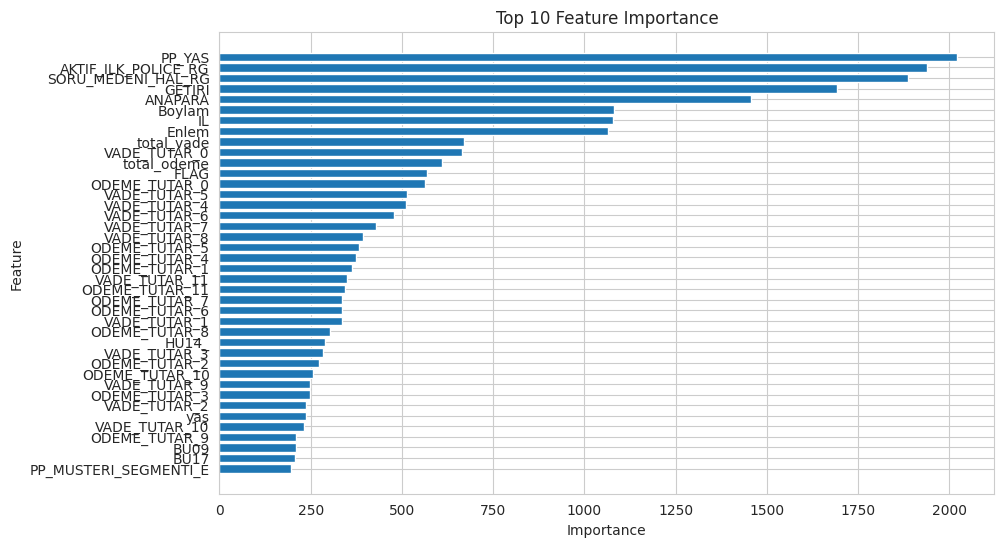

In [25]:
feature_importance = np.mean(importance,axis=0)
feature_importance_dict = dict(zip(features, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [x[0] for x in sorted_feature_importance]
sorted_importance = [x[1] for x in sorted_feature_importance]


plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:40], sorted_importance[:40])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

In [26]:

voting_classifier_sub = VotingClassifier(estimators=[
        
        ('lgbm', classifier1),
        ('xgb', classifier2),
        ('cat', classifier3),                                                                   
                                                                          ],voting='soft') 

voting_classifier_sub.fit(train[features],train.target)
ua_pred =  voting_classifier_sub.predict(test[features])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [27]:
test["ua_pred"] = ua_pred

In [28]:
# Ürün Alacak olarak tahminlenen kullanıcılar other yani yaklaşık 7bin kişi
test.ua_pred.value_counts()

ua_pred
UA       188657
other      6974
Name: count, dtype: int64

<div class="alert alert-block" style="font-size:22px; color: red; font-weight: bold;">
     &nbsp;Ürün Alacak Olarak Tahminlenen Kullanıcıların Hangi Ürünü Alabileceğinin Tahminlenmesi<br>
</div>

In [29]:
train_14 = train[train.LABEL!="UA"].drop("target",axis=1).reset_index(drop=True)
train_14.LABEL.value_counts()

LABEL
HU14    10754
HU07     3728
HU06     3178
HU19      759
HU12      676
HU11      439
HU15      415
Name: count, dtype: int64

In [30]:
# L.A. Shakers takımının çözümündeki parametreler

params = dict(
    allow_writing_files=False,
    iterations=1300,
    use_best_model=False,
    learning_rate=0.1,
    random_state=2,
    depth=6,
    border_count=254,
    l2_leaf_reg=3,
    grow_policy="Lossguide",
    bootstrap_type="Bernoulli",
    min_data_in_leaf=1,
    subsample=0.8,
    objective="MultiClassOneVsAll",
    eval_metric="TotalF1:average=Macro;use_weights=False",
    auto_class_weights="SqrtBalanced",
    silent=True
   
)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


model_train = train_14.copy()
scores = []
scores2 = []


proba_scores = []

mps = []

tests = []
preds = []
probalar = []

importance = []


skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skf.split(model_train.drop("LABEL",axis=1), model_train.LABEL):
    X_train, X_test = model_train.iloc[train_index,:], model_train.iloc[test_index,:]
    y_train, y_test = model_train.LABEL[train_index], model_train.LABEL[test_index]

    


    features = [ 'FLAG', 'PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG',
       'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11', 'ANAPARA',
       'GETIRI', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07',
       'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16',
       'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01',
       'HU02', 'HU03', 'HU04', 'HU05', 'HU06_', 'HU07_', 'HU10', 'HU11_',
       'HU12_', 'HU13', 'HU14_', 'HU15_', 'HU16', 'HU17', 'HU18', 'HU19_',
       'AKTIF_ILK_POLICE_RG', 'SORU_MEDENI_HAL_CVP_Divorced',
       'SORU_MEDENI_HAL_CVP_Marriage Cancelled', 'SORU_MEDENI_HAL_CVP_Married',
       'SORU_MEDENI_HAL_CVP_Other', 'SORU_MEDENI_HAL_CVP_Single',
       'SORU_MEDENI_HAL_CVP_Widowed', 'PP_MESLEK_Akademisyen',
       'PP_MESLEK_Banka', 'PP_MESLEK_Danışman', 'PP_MESLEK_Diğer',
       'PP_MESLEK_Emekli', 'emekli_bilinmiyor', 'emekli_vakıf',
       'PP_MESLEK_Esnaf', 'PP_MESLEK_Ev Hanımı',
       'PP_MESLEK_Finans Sektörü Çalışan', 'PP_MESLEK_Hekim',
       'PP_MESLEK_Memur', 'PP_MESLEK_Mühendis', 'PP_MESLEK_Ordu Mensubu',
       'PP_MESLEK_SSK-Sosyal Sigortalar Kurumu Emeklileri',
       'PP_MESLEK_Serbest Meslek','PP_MESLEK_Tacir ve Esnaf', 'PP_MESLEK_other', 'PP_MESLEK_Çiftçi',
       'PP_MESLEK_Öğrenci', 'PP_MESLEK_Öğretmen', 'PP_MESLEK_İş Adamı',
       'PP_MESLEK_İşyeri Sahibi/Ortağı', 'PP_MESLEK_İşçi',
       'SORU_YATIRIM_KARAKTERI_CVP_Bilge', 'SORU_YATIRIM_KARAKTERI_CVP_Cesur',
       'SORU_YATIRIM_KARAKTERI_CVP_Dengeli',
       'SORU_YATIRIM_KARAKTERI_CVP_Temkinli',
       'SORU_YATIRIM_KARAKTERI_CVP_Yetkin', 'SORU_EGITIM_CVP_(Diğer)',
       'SORU_EGITIM_CVP_Doktora', 'SORU_EGITIM_CVP_Lisans',
       'SORU_EGITIM_CVP_Lise', 'SORU_EGITIM_CVP_Yüksek Lisans',
       'SORU_EGITIM_CVP_Önlisans', 'SORU_EGITIM_CVP_İlköğretim',
       'PP_CINSIYET_erkek', 'PP_CINSIYET_kadın', 'PP_MUSTERI_SEGMENTI_A',
       'PP_MUSTERI_SEGMENTI_B', 'PP_MUSTERI_SEGMENTI_C',
       'PP_MUSTERI_SEGMENTI_D', 'PP_MUSTERI_SEGMENTI_E',
       'PP_MUSTERI_SEGMENTI_F', 'PP_UYRUK_MK', 'PP_UYRUK_TC', 'PP_UYRUK_YB',
       'yaş', 'Enlem', 'Boylam', 'yurtdışı', 'büyük_18', 'büyük_65',
       'küçük_15', '18_60', '18_50', 'total_odeme', 'total_vade', 'full_odeme',
 
    ]

 

 
    

    classifier2 = CatBoostClassifier(**params)

 
    
    voting_classifier = VotingClassifier(estimators=[
        

        ('cat', classifier2),                                   
                                                                          ],voting='soft') 

    
    
    
    X_test = X_test[features]
    X_train = X_train[features]
    

 
    ml = voting_classifier
    
    ml.fit(X_train ,y_train )
    
    predicted_ = ml.predict(X_test[features])
    score2 = f1_score(y_test,predicted_,average="macro")
    print("macro skor: ",score2)
    
 
    scores2.append(score2)
    
    importance.append(ml.estimators_[0].feature_importances_)
    
    
print()

print("mean  other f1 skoru", np.mean(scores2))


macro skor:  0.5373923536023061
macro skor:  0.5418356624441085
macro skor:  0.536017690243148

mean  other f1 skoru 0.5384152354298543


In [32]:
test_other = test[(test.ua_pred=="other")]
test_other["other_pred"] =  voting_classifier.predict(test_other[features])
test_other["other_pred"].value_counts()

/tmp/ipykernel_18/75230094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_other["other_pred"] =  voting_classifier.predict(test_other[features])


other_pred
HU14    3885
HU07    1635
HU06     904
HU19     263
HU11     134
HU12     108
HU15      45
Name: count, dtype: int64

In [33]:
tf3 = test_other[["MUSTERI_ID","other_pred"]]
tf3.columns = ["MUSTERI_ID","final"]

tf1 = test[test.ua_pred=="UA"]
tf1 = tf1[["MUSTERI_ID","ua_pred"]]
tf1.columns = ["MUSTERI_ID","final"]

In [34]:
sub = pd.concat([tf1,tf3])
sub.columns = ["MUSTERI_ID","LABEL"]
sub.to_csv("submission.csv",index=False)